# **Splitting Datasets**
*Splits the dataset into train and validation*

---





In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2
import gc
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.applications import DenseNet121,DenseNet169,DenseNet201


In [2]:
# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


In [3]:
train_df = pd.read_csv('train.csv')

In [4]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: ylabel='Frequency'>

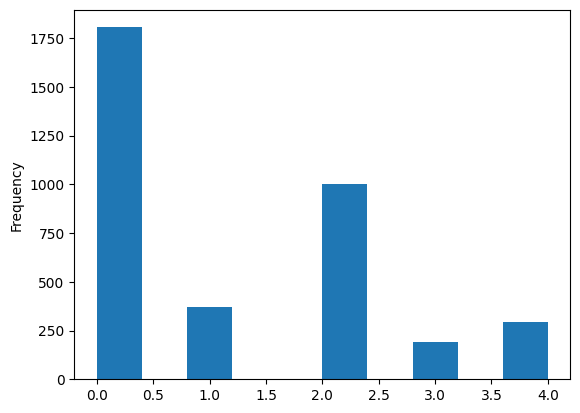

In [5]:
# distribution of classes in dataset ( which is imbalanced )
train_df['diagnosis'].plot(kind='hist')


In [6]:
# dimension of csv train file
train_df.shape

(3662, 2)

In [7]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # RGB to Grayscale
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img



In [8]:
def preprocess_image(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

def preprocess_image1(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res



In [9]:
N1 = train_df.shape[0]
x_train1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
for i, image_id in tqdm(enumerate((train_df['id_code']))):
    x_train1[i, :, :, :] = preprocess_image1(
        f'train_images/{image_id}.png'
    )

6it [00:05,  1.03it/s]


KeyboardInterrupt: 

In [19]:
y_train =train_df['diagnosis'].values

In [22]:
y_train

array([2, 4, 1, ..., 2, 0, 2])

In [21]:
np.save('y_train2.npy',y_train)

In [16]:
y_train

array([[False, False,  True, False, False],
       [False, False, False, False,  True],
       [False,  True, False, False, False],
       ...,
       [False, False,  True, False, False],
       [ True, False, False, False, False],
       [False, False,  True, False, False]])

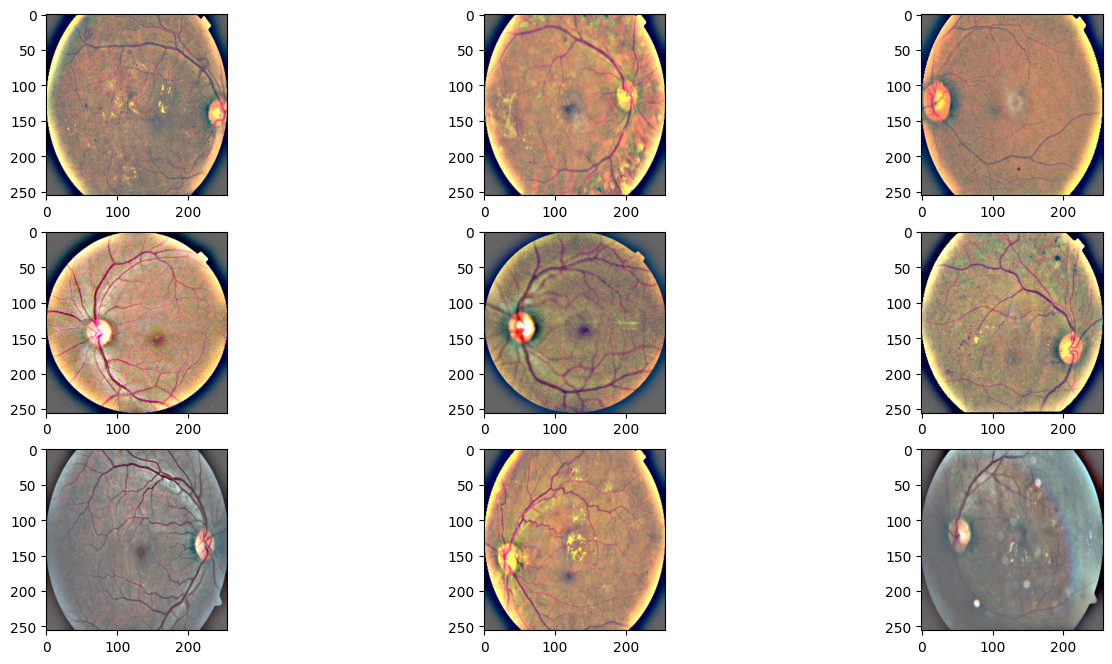

In [ ]:
plt.figure(figsize=(16,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train1[i])

In [ ]:
del N1
gc.collect()

25969

In [17]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [18]:
y_train_multi

array([[ True,  True,  True, False, False],
       [ True,  True,  True,  True,  True],
       [ True,  True, False, False, False],
       ...,
       [ True,  True,  True, False, False],
       [ True, False, False, False, False],
       [ True,  True,  True, False, False]])

In [ ]:
np.save('y_train1.npy',y_train_multi)
np.save('x_train1.npy',x_train1)